In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import t
import ta
from arch import arch_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve



from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [23]:
# Fetch data from Yahoo Finance
ticker = 'AAPL'  # Apple Inc.
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')


[*********************100%%**********************]  1 of 1 completed


In [24]:

# Data Preprocessing
data['Returns'] = data['Close'].pct_change()
data['Log_Returns'] = np.log(1 + data['Returns'])
data.dropna(inplace=True)

In [25]:
# Calculate the mean and standard deviation of log returns
mu = data['Log_Returns'].mean()
sigma = data['Log_Returns'].std()

In [26]:
# Calculate degrees of freedom, location, and scale for the t-distribution
# For simplicity, we're using the standard deviation and mean of log returns here
# In practice, you might want to fit the t-distribution to your data to find these parameters
df = len(data['Log_Returns']) - 1  # Degrees of freedom
loc = mu  # Location
scale = sigma  # Scale


In [27]:
# Monte Carlo Simulation Setup
simulation_df = pd.DataFrame()

In [33]:
# Number of trading days and simulations
num_days = 500
num_simulations = 10000

last_price = data['Close'][-1]

In [34]:
# Generate simulated price paths
for x in range(num_simulations):
    prices = [last_price]
    for _ in range(num_days):
        # Draw a random sample from the t-distribution
        rand_sample = t.rvs(df, loc=mu, scale=sigma)
        price = prices[-1] * np.exp(rand_sample)
        prices.append(price)
    
    simulation_df[x] = prices



C:\Users\user\AppData\Local\Temp\ipykernel_11748\544047246.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_df[x] = prices
C:\Users\user\AppData\Local\Temp\ipykernel_11748\544047246.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_df[x] = prices
C:\Users\user\AppData\Local\Temp\ipykernel_11748\544047246.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

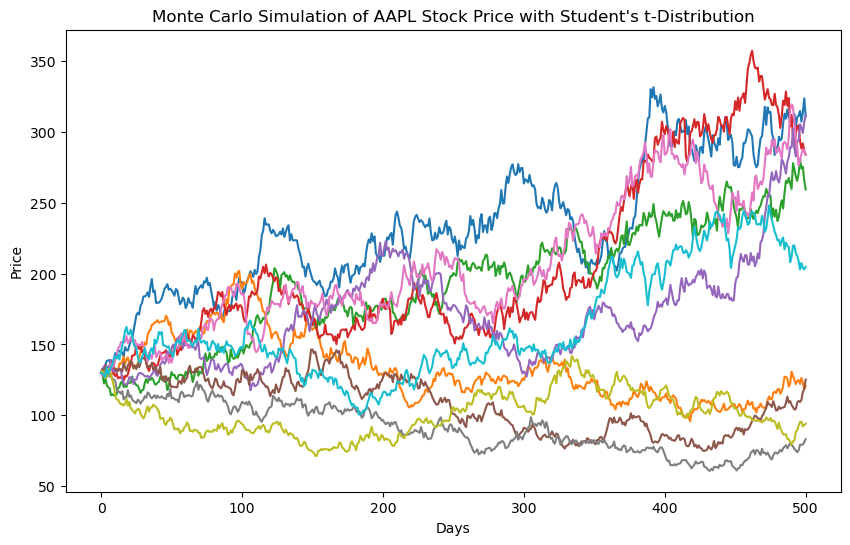

In [30]:
# Plotting the first 10 simulations
plt.figure(figsize=(10, 6))
plt.plot(simulation_df.iloc[:, :10])
plt.title('Monte Carlo Simulation of AAPL Stock Price with Student\'s t-Distribution')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [31]:
#data processi with gbm
data['Returns'] = data['Close'].pct_change()
data['Log_Returns'] = np.log(1 + data['Returns'])

# Adding technical indicators
data['MACD'] = ta.trend.MACD(data['Close']).macd_diff()
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
data['Bollinger_High'], data['Bollinger_Low'] = ta.volatility.bollinger_hband(data['Close']), ta.volatility.bollinger_lband(data['Close'])

data.dropna(inplace=True)


In [42]:
# Target variable
data['Target'] = (data['Returns'] > 0).astype(int)

# Features selection including technical indicators
X = data[['Log_Returns', 'MACD', 'RSI', 'Bollinger_High', 'Bollinger_Low']][:-1]
y = data['Target'][1:]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
}

grid_search = GridSearchCV(gbm, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model and predictions
best_gbm = grid_search.best_estimator_
predictions = best_gbm.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.07      0.12        89
           1       0.52      0.99      0.68        92

    accuracy                           0.54       181
   macro avg       0.69      0.53      0.40       181
weighted avg       0.69      0.54      0.41       181

Confusion Matrix:
[[ 6 83]
 [ 1 91]]
